[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/MDOFsimulator.ipynb)

# Simulation of multiple degrees-of-freedom (MDOF) systems

References:
- Khalid Jawed, "Notes on Discrete Simulation of Slender Structures", chapters 3 and 4.

Recall the equations of motion (with initial conditions) for a MDOF system subject to
conservative, non-conservative, and viscous forces, written as a system of first order ODEs:
$$ \begin{cases}
    \dot{v}_i = \frac{1}{m_i} \left(-\frac{\partial E_p}{\partial q_i} - c v_i
    + F_i\right) \\
    v_i = \dot{q}_i \\
    q_i(0) = q_{i0} \\
    v_i(0) = v_{i0}
\end{cases}
$$
where $q_i$ are the degrees of freedom ($i = 1,..,N$), $v_i$ are the associated
velocities, $m_i$ are the lumped masses, $c$ is the viscous dissipation coefficien,
$F_i$ are the non-conservative forces, and $E_p$ is the potential energy corresponding
to the conservative forces.

In [1]:
# Use JAX on CPU
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import jax.numpy as jnp
from jax import jacfwd, jit, grad, config
from functools import partial
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

config.update("jax_enable_x64", True)

In [21]:
# Equations of motion (system of first order ODEs to integrate)
@partial(jit, static_argnames=("P",))
def equations_of_motion(t, z, P, m, c=0., F=0.):
    q, v = jnp.array_split(z, 2) # split state into positions and velocity
    q = q.at[0:2].set(0)
    q = q.at[-1].set(0)
    v = v.at[0:2].set(0)
    v = v.at[-1].set(0)
    dq_dt = v
    dv_dt = -grad(P)(q)/m-c*v/m+F/m
    return jnp.concatenate([dq_dt, dv_dt])

# Jacobian of the rhs of the system of equations of motion
@partial(jit, static_argnames=("P",))
def jacobian(t, z, P, m, c=0., F=0.):
    return jacfwd(equations_of_motion, argnums=1)(t, z, P, m, c, F)

### 2 masses, 1 spring

In [5]:
# Initial conditions
q0 = jnp.array([0., 1.1])  # initial positions
v0 = jnp.array([0., 0.])  # initial velocities
z0 = jnp.concatenate([q0, v0])

# Masses and stiffnesses
m = jnp.ones(2)

# Potential energy
def S(q):
    return 0.5*(q[1]-q[0] - 1.)**2

# Kinetic energy
def K(v):
    return 0.5*jnp.sum(m * v**2)

# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = jnp.linspace(t_span[0], t_span[1], 1000)  # points at which to store the solution

# Solve the system using RK45 (explicit method)
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m), t_eval=t_eval)
# Solve the system using BDF (implicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(S, m), method="BDF", t_eval=t_eval, jac=jacobian)

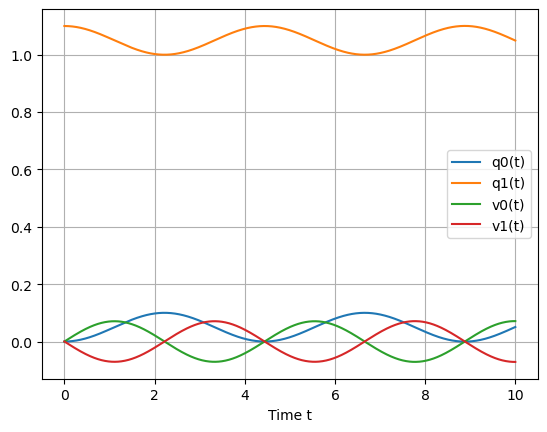

In [6]:
# Plot the results
plt.plot(sol.t, sol.y[0], label='q0(t)')
plt.plot(sol.t, sol.y[1], label='q1(t)')
plt.plot(sol.t, sol.y[2], label='v0(t)')
plt.plot(sol.t, sol.y[3], label='v1(t)')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

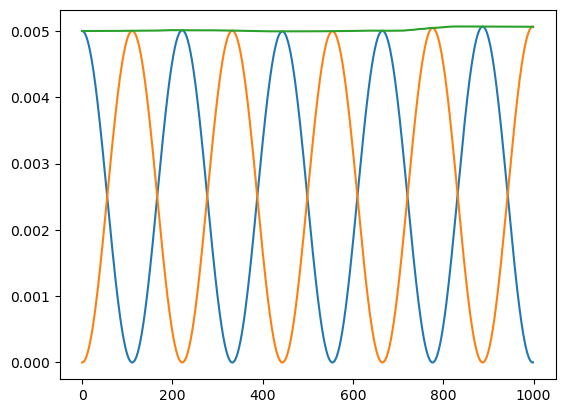

In [7]:
from jax import vmap
q, v = np.split(sol.y, 2)
potential_energy = vmap(S, in_axes=(1,))(q)
kinetic_energy = vmap(K, in_axes=(1,))(v)
plt.plot(potential_energy)
plt.plot(kinetic_energy)
plt.plot(potential_energy + kinetic_energy)
plt.show()

### Verlet time integration

In [105]:
def velocity_verlet(t, dt, z, P, equations_of_motion, m, c=0., F=0.):
    q, v = jnp.split(z, 2) 
    a = equations_of_motion(t, z, P, m, c, F)[len(q):] 
    q = q + v*dt + 0.5*a*dt**2
    z = jnp.concatenate([q, v])
    new_a = equations_of_motion(t, z, P, m, c, F)[len(q):]
    v = v + 0.5*(new_a + a) * dt
    return jnp.concatenate([q, v])

In [9]:
z = z0
dt = 0.001
times = np.arange(0., 10., dt)
zs = np.zeros((len(z0), len(times)))
for i,t in enumerate(times):
    z = velocity_verlet(t, dt, z, S, equations_of_motion, m) 
    zs[:,i] = z

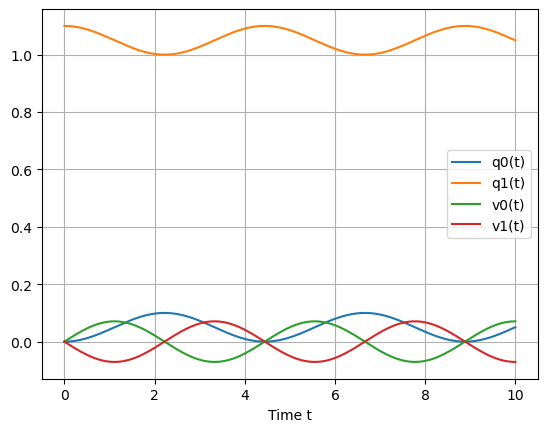

In [10]:
# Plot the results
plt.plot(times, zs[0], label='q0(t)')
plt.plot(times, zs[1], label='q1(t)')
plt.plot(times, zs[2], label='v0(t)')
plt.plot(times, zs[3], label='v1(t)')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

### Rigid spheres and elastic beam falling in a viscous fluid

In [11]:
N = 11 # number of spheres (must be odd)
l = 0.1 # total length of the rod
dl = l/(N-1)
xs = jnp.linspace(0., l, N).reshape(-1,1) # array of the x coords as a column
ys = jnp.zeros((N,1))
q0 = jnp.hstack([xs, ys]).ravel()
print(q0)
v0 = jnp.zeros(2*N)
z0 = jnp.concatenate([q0, v0])

[0.   0.   0.01 0.   0.02 0.   0.03 0.   0.04 0.   0.05 0.   0.06 0.
 0.07 0.   0.08 0.   0.09 0.   0.1  0.  ]


In [12]:
# Material parameters
E = 1e9 # Young's modulus
r0 = 1e-3 # beam radius
EA = E*np.pi*r0**2 # stretching stiffenss
EI = E*np.pi*r0**4/4 # bending stiffness
rho_m = 7000. # density of the metal (spheres)
rho_f = 1000. # density of the fluid
radii = 5e-3*np.ones(2*N) # radii of the spheres (2 per dof)
radii[N-1:N+1] = 25e-3
V = 4/3*np.pi*np.power(radii, 3) # volumes of the spheres
m = rho_m * V # masses of the spheres
mu = 1000. # fluid viscosity

# Viscous damping coefficients
c = 6*np.pi*mu*radii

# Buoyancy forces
y_components = np.ones(2*N)
y_components[::2] = 0. # select the dofs corresponding to y components
F = -V*y_components*(rho_m-rho_f)*9.81

In [20]:
# Geometry functions
def compute_edge_vectors(q):
    p_vec = q.reshape(-1,2)
    return p_vec[1:,:] - p_vec[:-1,:]

def compute_curvatures(edge_vectors_norm):
    cos_turning_angles = jnp.sum(edge_vectors_norm[1:] * edge_vectors_norm[:-1], axis=1)
    sin_turning_angles = jnp.cross(edge_vectors_norm[1:], edge_vectors_norm[:-1], axis=1)
    tan_theta_half = sin_turning_angles/(1+cos_turning_angles)
    return 2*tan_theta_half/dl

# Stretching energy
def S(q):
    edge_vectors = compute_edge_vectors(q)
    stretch = (1/dl)*jnp.linalg.norm(edge_vectors, axis=1)
    return 0.5*EA*jnp.sum((1.-stretch)**2*dl)

# Bending energy
def B(q):
    edge_vectors = compute_edge_vectors(q)
    edge_vectors_norm = edge_vectors / jnp.linalg.norm(edge_vectors, axis=1).reshape(-1,1)
    # edge_vectors_norm = edge_vectors
    curvatures = compute_curvatures(edge_vectors_norm)
    return 0.5*EI*jnp.sum(curvatures**2*dl)

# Total potential energy
def P(q):
    return S(q) + B(q)


In [14]:
%timeit jacobian(0., z0, P, m, c, F)

27 µs ± 9.45 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# Time span
t_span = (0, 10)  # from t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the solution

# LINK TO scipy doc about solve_ivp and docs about RK45 and BDF
# Solve the system using RK45 (explicit method)
# sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), t_eval=t_eval)
# Solve the system using BDF (implicit method)
sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), method="BDF", t_eval=t_eval, jac=jacobian)

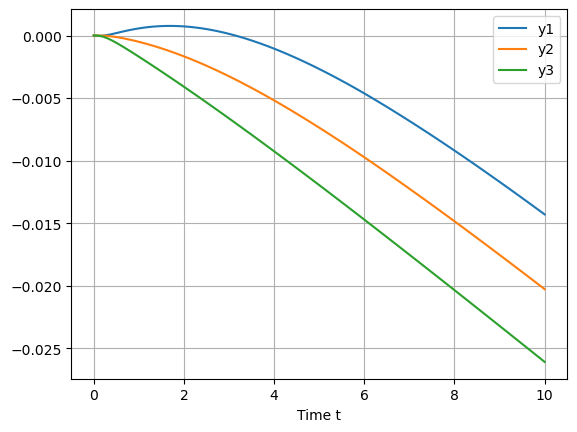

In [16]:
q, v = np.split(sol.y, 2)
plt.plot(sol.t, q[1], label='y1')
plt.plot(sol.t, q[3], label='y2')
plt.plot(sol.t, q[5], label='y3')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

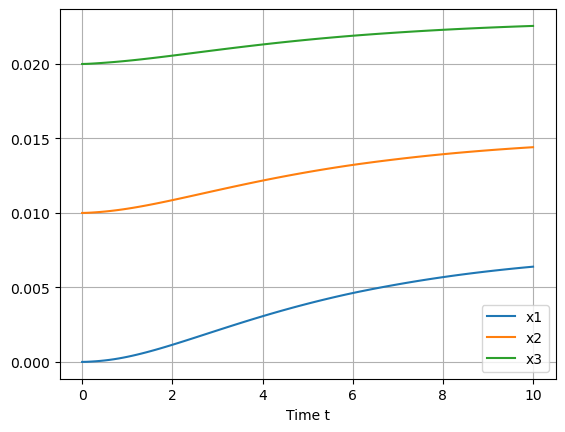

In [17]:
plt.plot(sol.t, q[0], label='x1')
plt.plot(sol.t, q[2], label='x2')
plt.plot(sol.t, q[4], label='x3')
plt.xlabel('Time t')
plt.legend()
plt.grid(True)
plt.show()

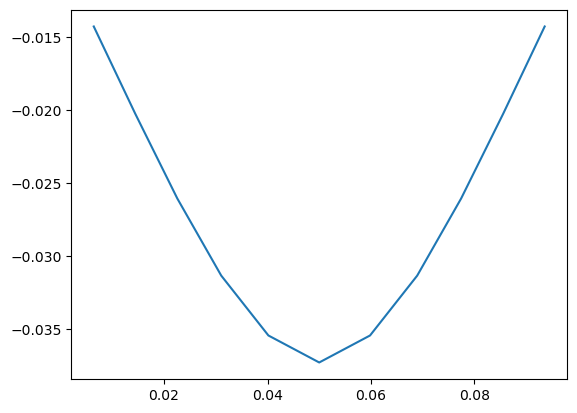

In [18]:
# Plot the final configuration of the rod
plt.plot(q[::2,-1],q[1::2,-1])
plt.show()

### Bending of a simply-supported rod

In [332]:
N = 51 # number of nodes
l = 1. # total length of the rod
dl = l/(N-1)
xs = jnp.linspace(0., l, N).reshape(-1,1)
ys = jnp.zeros((N,1))
q0 = jnp.hstack([xs, ys]).ravel()
v0 = jnp.zeros(2*N)
z0 = jnp.concatenate([q0, v0])

In [334]:
E = 70e9
R = 0.013
r = 0.011
I = np.pi/4*(R**4 - r**4)
EA = E*np.pi*(R**2 - r**2)
EI = E*I
rho = 2700
m = np.pi*(R**2-r**2)*l*rho/(N-1)
c = 5.

In [346]:
t_span = (0, 0.1)
t_eval = np.linspace(t_span[0], t_span[1], 100)  # points at which to store the solution

y_components = np.ones(2*N)
y_components[::2] = 0. # select the dofs corresponding to y components

y_theory = []
y_num = []

loads = np.linspace(1000, 10000, 10)

for load in loads:
    print(load)
    P0 = load/N # distribute load over nodes
    F = -P0*y_components
    # vertical displacement according to linear beam theory
    w = -load/l
    y_theory.append(5*w*l**4/(384*EI))

    sol = solve_ivp(equations_of_motion, t_span, z0, args=(P, m, c, F), method="LSODA", t_eval=t_eval, jac=jacobian)

    q, v = np.split(sol.y, 2)
    y_num.append(q[N][-1]) # record y-displacement of the midpoint at final time

1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0


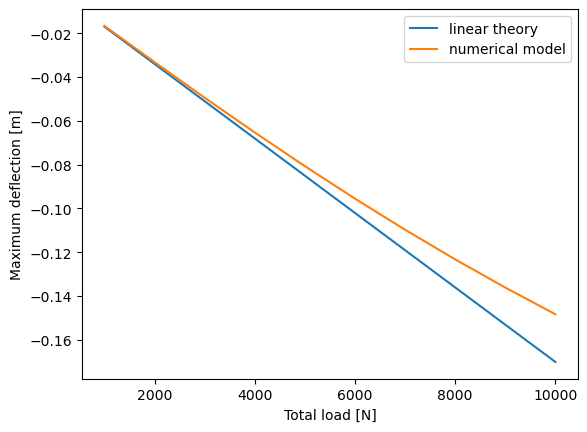

In [347]:
plt.plot(loads, y_theory, label="linear theory")
plt.plot(loads, y_num, label="numerical model")
plt.xlabel("Total load [N]")
plt.ylabel("Maximum deflection [m]")
plt.legend()
plt.show()

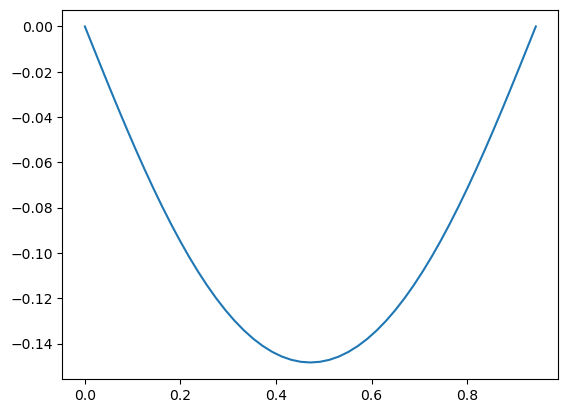

In [348]:
plt.plot(q[::2,-1],q[1::2,-1])
plt.show()

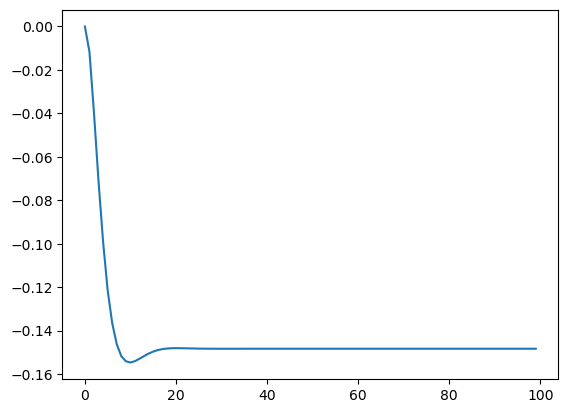

In [349]:
plt.plot(q[N])
plt.show()